<a href="https://colab.research.google.com/github/NevesJulio/Exercicios_DL/blob/main/Atividade_DeepLearning_Labubu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade: CNNs para Classificação

Neste notebook, iremos preparar nosso próprio dataset e treinar um modelo de classificação de imagens.

## Preparando os dados

Os dados desta atividade serão baixados da internet. Utilizaremos para isso buscadores comuns. Em seguida, dividiremos em treinamento e validação.

In [1]:
%pip install icrawler

In [49]:
import os
import shutil
import random
from icrawler.builtin import GoogleImageCrawler, BingImageCrawler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils, datasets, models
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
from PIL import Image
import glob
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns



### Adquirindo as Imagens

Utilizaremos o iCrawler para baixar imagens em buscadores através de termos especificados. Defina sua lista de classes.

In [3]:
def download_images(keyword, folder, n_total=100):
    os.makedirs(folder, exist_ok=True)
    downloaded = len(os.listdir(folder))
    remaining = n_total - downloaded

    while downloaded < n_total:
        crawler = GoogleImageCrawler(storage={'root_dir': folder})
        crawler.crawl(keyword=keyword, max_num=remaining, file_idx_offset=downloaded)
        downloaded = len(os.listdir(folder))
        remaining = n_total - downloaded
        print(f"Downloaded {downloaded}/{n_total}")

    print("Download complete!")

In [4]:
search_terms = {
     "Labubu": "Labubu", # nome da classe: termo que será usado na busca
     "Pikachu": "pikachu",
     "sagui": "sagui"

}

for label, term in search_terms.items():
    download_images(term, f"data/Julio/{label}", n_total=100)

ERROR:downloader:Response status code 403, file https://media.asiaone.com/sites/default/files/styles/article_top_image/public/original_images/Sep2024/20242709%20Labubu.jpg
ERROR:downloader:Response status code 404, file https://i0.wp.com/zaloramalaysiablog.wpcomstaging.com/wp-content/uploads/2024/10/20240617_101957_041165____2_____1200x1200.jpg
ERROR:downloader:Exception caught when downloading file https://cdn-images.farfetch-contents.com/31/78/64/07/31786407_61234927_600.jpg, error: HTTPSConnectionPool(host='cdn-images.farfetch-contents.com', port=443): Read timed out. (read timeout=5), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://cdn-images.farfetch-contents.com/31/78/64/07/31786407_61234927_600.jpg, error: HTTPSConnectionPool(host='cdn-images.farfetch-contents.com', port=443): Read timed out. (read timeout=5), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file https://cdn-images.farfetch-contents.com/31/78/64

Downloaded 59/100


ERROR:downloader:Response status code 403, file https://media.asiaone.com/sites/default/files/styles/article_top_image/public/original_images/Sep2024/20242709%20Labubu.jpg
ERROR:downloader:Response status code 404, file https://i0.wp.com/zaloramalaysiablog.wpcomstaging.com/wp-content/uploads/2024/10/20240617_101957_041165____2_____1200x1200.jpg
ERROR:downloader:Exception caught when downloading file https://cdn-images.farfetch-contents.com/31/78/64/07/31786407_61234927_600.jpg, error: HTTPSConnectionPool(host='cdn-images.farfetch-contents.com', port=443): Read timed out. (read timeout=5), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://cdn-images.farfetch-contents.com/31/78/64/07/31786407_61234927_600.jpg, error: HTTPSConnectionPool(host='cdn-images.farfetch-contents.com', port=443): Read timed out. (read timeout=5), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file https://cdn-images.farfetch-contents.com/31/78/64

Downloaded 100/100
Download complete!


ERROR:downloader:Response status code 403, file https://static.wikia.nocookie.net/thepokemonshow/images/8/80/20101007155439%21Ash_Pikachu.png
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnectionPool(host='www.freeiconspng', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7bf2c641b170>: Failed to resolve 'www.freeiconspng' ([Errno -2] Name or service not known)")), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnectionPool(host='www.freeiconspng', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7bf2c641b530>: Failed to resolve 'www.freeiconspng' ([Errno -2] Name or service not known)")), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnecti

Downloaded 59/100


ERROR:downloader:Response status code 403, file https://static.wikia.nocookie.net/thepokemonshow/images/8/80/20101007155439%21Ash_Pikachu.png
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnectionPool(host='www.freeiconspng', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7bf2d83424b0>: Failed to resolve 'www.freeiconspng' ([Errno -2] Name or service not known)")), remaining retry times: 2
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnectionPool(host='www.freeiconspng', port=443): Max retries exceeded with url: / (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x7bf2d8343740>: Failed to resolve 'www.freeiconspng' ([Errno -2] Name or service not known)")), remaining retry times: 1
ERROR:downloader:Exception caught when downloading file https://www.freeiconspng, error: HTTPSConnecti

Downloaded 100/100
Download complete!


ERROR:downloader:Response status code 403, file https://www.petz.com.br/blog/wp-content/uploads/2025/04/macaco-sagui-4-scaled.jpg
ERROR:downloader:Response status code 404, file https://t3.ftcdn.net/jpg
ERROR:downloader:Response status code 400, file https://media.istockphoto.com/id/1472424290/photo/sagui.jpg
ERROR:downloader:Response status code 404, file https://as2.ftcdn.net/jpg
ERROR:downloader:Response status code 400, file https://media.gettyimages.com/id/999647864/photo/sagui-de-tufos-brancos.jpg
ERROR:downloader:Response status code 403, file https://www.petz.com.br/blog/wp-content/uploads/2025/04/macaco-sagui-1-scaled.jpg
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resources/previews/040/970/980/large_2x/sagui-monkey-in-the-wild-eating-a-piece-of-banana-in-the-countryside-of-sao-paulo-brazil-photo.jpg
ERROR:downloader:Response status code 403, file https://preview.redd.it/i-finded-a-cute-monkey-in-brazil-called-sagui-v0-v2pafbspulad1.png


Downloaded 51/100


ERROR:downloader:Response status code 403, file https://www.petz.com.br/blog/wp-content/uploads/2025/04/macaco-sagui-4-scaled.jpg
ERROR:downloader:Response status code 404, file https://t3.ftcdn.net/jpg
ERROR:downloader:Response status code 404, file https://upload.wikimedia.org/wikipedia/commons/thumb/7/7f/Filhote_de_macaco_da_esp%C3%A9cie_Sagui.jpg
ERROR:downloader:Response status code 404, file https://as2.ftcdn.net/jpg
ERROR:downloader:Response status code 400, file https://media.gettyimages.com/id/999647864/photo/sagui-de-tufos-brancos.jpg
ERROR:downloader:Response status code 403, file https://www.researchgate.net/publication/331888899/figure/fig1/AS:738371102056448@1553052797631/Figura-1-A-esquerda-sagui-Callithrix-penicillata-adulto-com-padrao-de-coloracao-da.png
ERROR:downloader:Response status code 403, file https://www.petz.com.br/blog/wp-content/uploads/2025/04/macaco-sagui-1-scaled.jpg
ERROR:downloader:Response status code 403, file https://static.vecteezy.com/system/resou

Downloaded 100/100
Download complete!


### Treinamento e Validação

Dividiremos as imagens baixadas nas pastas `train` e `val`. Defina uma porcentagem.

In [7]:
def split_train_val(root_dir, train_ratio=0.8, seed=42):
    random.seed(seed)

    train_dir = root_dir + "_split/train"
    val_dir = root_dir + "_split/val"

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        images = [os.path.join(class_path, f) for f in os.listdir(class_path)]
        images = [f for f in images if os.path.isfile(f)]
        random.shuffle(images)

        n_train = int(len(images) * train_ratio)

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)

        for img in images[:n_train]:
            shutil.copy(img, os.path.join(train_class_dir, os.path.basename(img)))
        for img in images[n_train:]:
            shutil.copy(img, os.path.join(val_class_dir, os.path.basename(img)))

        print(f"{class_name}: {n_train} train, {len(images)-n_train} val")

In [8]:
split_train_val("data/Julio")

Pikachu: 80 train, 20 val
sagui: 80 train, 20 val
Labubu: 80 train, 20 val


## Dataset

Implemente um Dataset PyTorch que carregue as imagens baixadas com suas respectivas classes. Aplique data augmentation e carregue em batches.

In [9]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.class_names = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}

        self.data = []
        for class_name in self.class_names:
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    path = os.path.join(class_dir, filename)
                    item = (path, self.class_to_idx[class_name])
                    self.data.append(item)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [33]:
DATA_DIR = "Data/DataSet"
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4
DEVICE = "cuda"
MODEL_NAME = "resnet50"
n_runs = 1
histories = {}
num_classes = 3
DROPOUT_RATE = 0.4


train_dataset = CustomImageDataset("data/Julio_split/train", transform = data_transforms["train"])
val_dataset   = CustomImageDataset("data/Julio_split/val", transform = data_transforms["val"])


In [29]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=1, pin_memory=True)

In [12]:

# # Obtém um batch de dados de treino
#inputs, classes = next(iter(train_dataloader))

# # Cria uma grade a partir do batch
# out = utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

## Definição do Modelo

Defina aqui o modelo que será utilizado, sendo implementação própria ou um modelo pré-treinado.

In [13]:
class CustomHead(nn.Module):
    def __init__(self, in_features, num_classes, dropout_p=0.5):
        super().__init__()
        self.in_features = in_features
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Dropout(dropout_p),
            nn.Linear(in_features, 512),
            nn.ReLU(),

            nn.BatchNorm1d(512),
            nn.Dropout(dropout_p),
            nn.Linear(512, 128),
            nn.ReLU(),

            nn.BatchNorm1d(128),
            nn.Dropout(dropout_p),
            nn.Linear(128, 32),
            nn.ReLU(),

            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [23]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
model.fc = CustomHead(model.fc.in_features, 3, DROPOUT_RATE)


In [37]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs, save_path, num_classes=2):
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": [],
        "precision": [], "recall": [], "f1": [],
        "roc_auc": [], "roc_curves": [],
        "val_labels": [], "val_preds": []
    }


    for epoch in range(1, epochs + 1):

#Treino
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False, colour="green")
        for images, labels in loop:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item(), acc=f"{correct/total:.4f}")

        train_loss /= total
        train_acc = correct / total

#validação
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        all_probs = []

        loop = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]  ", leave=False, colour="blue")
        with torch.no_grad():
            for images, labels in loop:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                if num_classes == 2:
                    all_probs.extend(torch.softmax(outputs, dim=1)[:,1].cpu().numpy())  # probs da classe positiva

                loop.set_postfix(loss=loss.item(), acc=f"{correct/total:.4f}")
        # adiciona dentro do dicionário history

        history["val_labels"] = all_labels
        history["val_preds"] = all_preds

        val_loss /= total
        val_acc = correct / total

        # ---- Métricas sklearn ----
        precision = precision_score(all_labels, all_preds, average= "macro")
        recall = recall_score(all_labels, all_preds, average= "macro")
        f1 = f1_score(all_labels, all_preds, average= "macro")


        print(f"Epoch {epoch}/{epochs} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} | "
              f"Prec: {precision:.4f} Rec: {recall:.4f} F1: {f1:.4f}")

        # ---- Salvar histórico ----
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["precision"].append(precision)
        history["recall"].append(recall)
        history["f1"].append(f1)

    # ---- Salvar modelo ----
    torch.save(model.state_dict(), save_path)
    print(f"Modelo salvo em {save_path}")

    return history

In [38]:

for name, param in model.named_parameters():
    if "layer3" not in name and "layer4" not in name:
        param.requires_grad = False

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
filter(lambda p: p.requires_grad, model.parameters()),
lr=1e-4,
weight_decay=0.02  # L2 regularization
)


for i in range(n_runs):
    print(f"\n===== Run {i+1}/{n_runs} =====")

    scheduler = OneCycleLR(optimizer, max_lr=LR, steps_per_epoch=len(train_loader), epochs=EPOCHS)

    # Treina e retorna histórico
    history = train_and_validate(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        scheduler=scheduler,
        device=DEVICE,
        epochs=EPOCHS,
        save_path=f"{MODEL_NAME}_run{i}.pth",
        num_classes=num_classes
    )

    histories[f"run_{i}"] = history


    # Plota e salva gráficos
    plot_history(history, model_name=f"{MODEL_NAME}_run{i}")



===== Run 1/1 =====


Epoch 1/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10 | Train Loss: 1.0479 Acc: 0.4542 | Val Loss: 1.0237 Acc: 0.5833 | Prec: 0.5946 Rec: 0.5833 F1: 0.5651


Epoch 2/10 [Train]:  25%|██▌       | 2/8 [00:01<00:04,  1.33it/s, acc=0.5312, loss=1.05]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 2/10 | Train Loss: 1.0294 Acc: 0.4917 | Val Loss: 0.9332 Acc: 0.8333 | Prec: 0.8422 Rec: 0.8333 F1: 0.8291


Epoch 3/10 [Train]:  50%|█████     | 4/8 [00:04<00:04,  1.15s/it, acc=0.5859, loss=1.02]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 3/10 | Train Loss: 0.9340 Acc: 0.6250 | Val Loss: 0.7909 Acc: 0.9333 | Prec: 0.9406 Rec: 0.9333 F1: 0.9316


Epoch 4/10 [Train]:  62%|██████▎   | 5/8 [00:04<00:02,  1.22it/s, acc=0.7812, loss=0.789]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 4/10 | Train Loss: 0.8161 Acc: 0.7875 | Val Loss: 0.6631 Acc: 0.9833 | Prec: 0.9841 Rec: 0.9833 F1: 0.9833


Epoch 5/10 [Train]:  38%|███▊      | 3/8 [00:02<00:03,  1.36it/s, acc=0.8021, loss=0.807]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 5/10 | Train Loss: 0.7462 Acc: 0.8208 | Val Loss: 0.5908 Acc: 0.9833 | Prec: 0.9841 Rec: 0.9833 F1: 0.9833


Epoch 6/10 [Train]:  12%|█▎        | 1/8 [00:00<00:05,  1.31it/s, acc=0.9375, loss=0.722]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 6/10 | Train Loss: 0.7012 Acc: 0.8792 | Val Loss: 0.5538 Acc: 1.0000 | Prec: 1.0000 Rec: 1.0000 F1: 1.0000


Epoch 7/10 [Train]:  12%|█▎        | 1/8 [00:00<00:05,  1.37it/s, acc=0.8750, loss=0.689]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 7/10 | Train Loss: 0.6529 Acc: 0.8958 | Val Loss: 0.5327 Acc: 1.0000 | Prec: 1.0000 Rec: 1.0000 F1: 1.0000


Epoch 8/10 [Train]:  25%|██▌       | 2/8 [00:01<00:05,  1.16it/s, acc=0.9219, loss=0.616]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 8/10 | Train Loss: 0.6354 Acc: 0.9125 | Val Loss: 0.5285 Acc: 1.0000 | Prec: 1.0000 Rec: 1.0000 F1: 1.0000


Epoch 9/10 [Train]:  12%|█▎        | 1/8 [00:00<00:06,  1.02it/s, acc=0.8750, loss=0.669]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 9/10 | Train Loss: 0.6331 Acc: 0.9083 | Val Loss: 0.5338 Acc: 1.0000 | Prec: 1.0000 Rec: 1.0000 F1: 1.0000


Epoch 10/10 [Train]:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 10/10 | Train Loss: 0.6373 Acc: 0.9042 | Val Loss: 0.5437 Acc: 1.0000 | Prec: 1.0000 Rec: 1.0000 F1: 1.0000
Modelo salvo em resnet50_run0.pth


NameError: name 'pd' is not defined

In [45]:
def plot_history(history, model_name="modelo", save_dir="plots"):
    """
    Gera gráficos de métricas a partir do dicionário `history` retornado pelo treino
    e salva os gráficos em arquivos PNG.
    """

    # --- Loss ---
    plt.figure(figsize=(10,5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title(f"Loss - {model_name}")
    plt.legend()
    plt.show()

    # --- Acurácia ---
    plt.figure(figsize=(10,5))
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.title(f"Acurácia - {model_name}")
    plt.legend()
    plt.show()

    # --- Precisão / Recall / F1 ---
    plt.figure(figsize=(10,5))
    plt.plot(history["precision"], label="Precisão")
    plt.plot(history["recall"], label="Recall")
    plt.plot(history["f1"], label="F1-score")
    plt.xlabel("Época")
    plt.ylabel("Score")
    plt.title(f"Métricas - {model_name}")
    plt.legend()
    plt.show()

    # --- ROC final ---
    if any(history["roc_curves"]):
        # pega a última curva (última época)
        last_fpr, last_tpr = history["roc_curves"][-1]
        plt.figure(figsize=(6,6))
        plt.plot(last_fpr, last_tpr, label="ROC final")
        plt.plot([0,1], [0,1], 'k--', label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC final - {model_name}")
        plt.legend()
        plt.show()

    # --- Matriz de confusão ---
    if "val_labels" in history and "val_preds" in history:
        cm = confusion_matrix(history["val_labels"], history["val_preds"])
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Matriz de Confusão - {model_name}")
        plt.show()


## Treinamento

Defina a função de custo e o otimizador do modelo. Em seguida, implemente o código de treinamento e treine-o. Ao final, exiba as curvas de treinamento e validação para a loss e a acurácia.

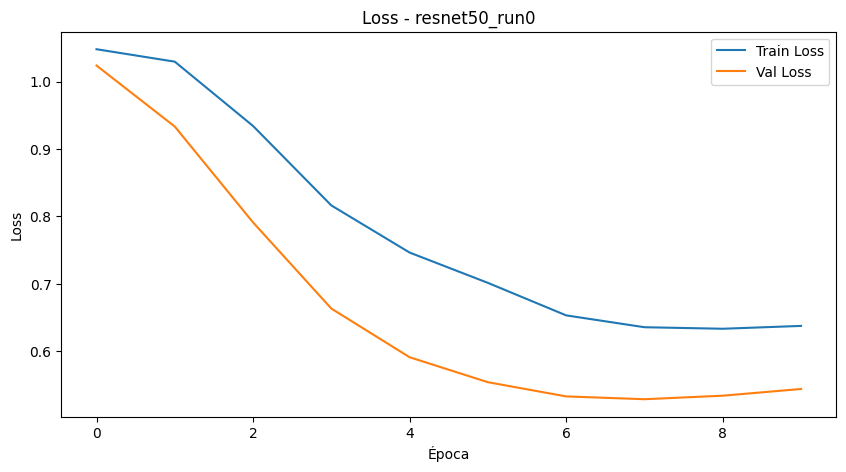

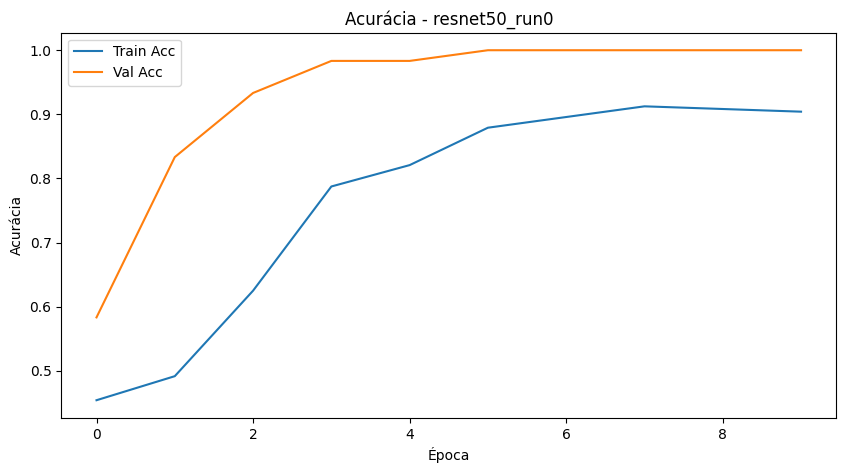

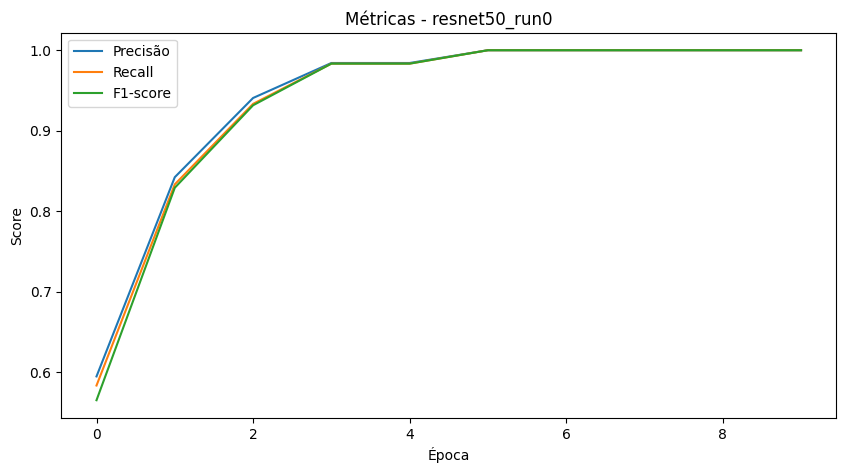

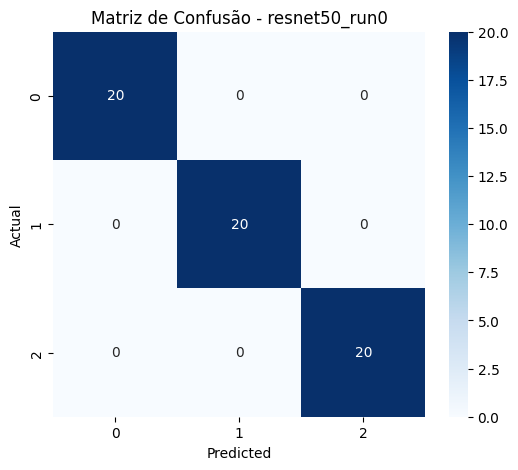

In [50]:
plot_history(history, model_name=f"{MODEL_NAME}_run{i}")

## Inferência

Calcule algumas métricas como acurácia, matriz de confusão, etc. Em seguida, teste o modelo em novas imagens das classes correspondentes mas de outras fontes (outro buscador, fotos próprias, etc).

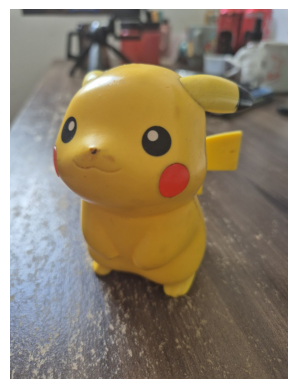

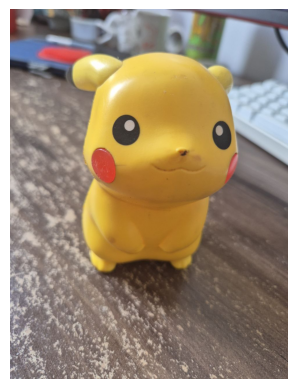

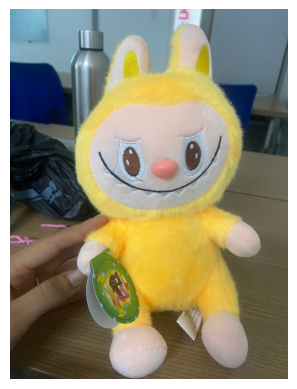

In [71]:
Image_path = "data/Imagens_teste"

# Lista todos os arquivos .jpg/.png da pasta
imagens = [os.path.join(Image_path, f) for f in os.listdir(Image_path)
           if f.endswith(('.png', '.jpg', '.jpeg'))]

for img_path in imagens:
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')  # remove os eixos
    plt.show()

In [72]:
Imagens_teste = CustomImageDataset(Image_path, transform = data_transforms["val"])



In [76]:
nomes = ["pikachu", "sagui", "labubu"]

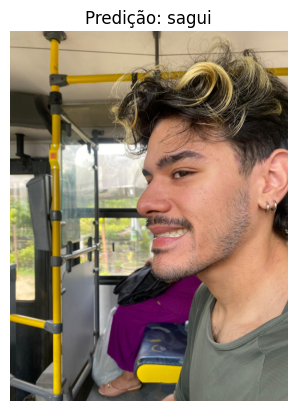

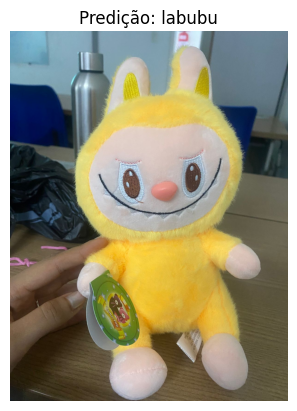

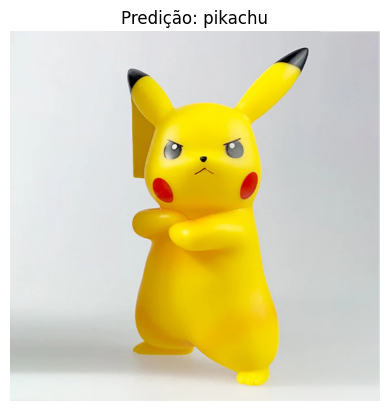

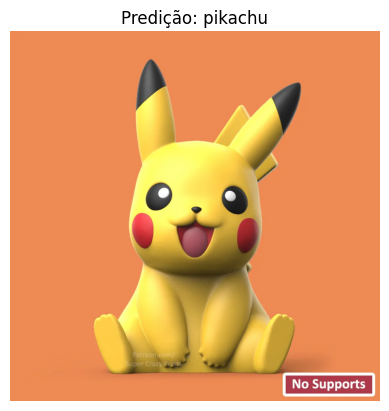

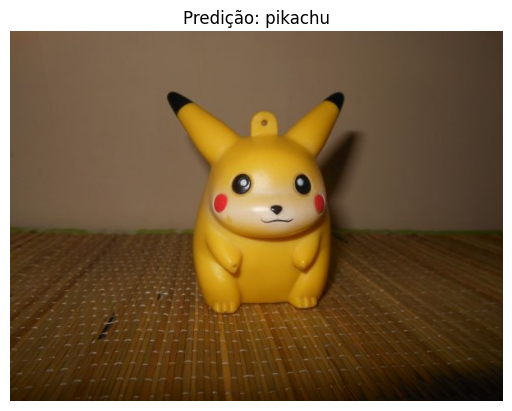

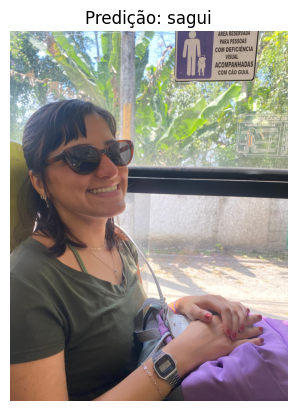

In [79]:
def prever_Imagens(model, image_path, class_names):

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    img = Image.open(image_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0)

    # Move input para o mesmo dispositivo do modelo
    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    model.eval()

    # Avaliando a imagem
    with torch.no_grad():
        output = model(input_tensor)
        probs = torch.softmax(output, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()

    # Mostrando a imagem e a classe prevista
    plt.imshow(img)
    plt.title(f"Predição: {class_names[pred_class]}")
    plt.axis('off')
    plt.show()




Image_path = "data/Imagens_teste"

# Lista todos os arquivos .jpg/.png da pasta
imagens = [os.path.join(Image_path, f) for f in os.listdir(Image_path)
           if f.endswith(('.png', '.jpg', '.jpeg'))]

for img_path in imagens:
  prever_Imagens(model, img_path, nomes)

